In [ ]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple
import cPickle as pickle
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

from multiprocessing.dummy import Pool as ThreadPool
import itertools

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial

from thesis.utils.metrics import *

In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
IS_SAMPLE = False

In [4]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234
WORD2VEC_SEED = 1234

In [5]:
NUMBER_INDICATOR = "number_inidicator"
CURRENCY_INDICATOR = "currency_inidicator"
CHEMICAL_INDICATOR = "chemical_inidicator"
MIN_WORD_COUNT = 100
MIN_SIZE = 0
NUM_CORES = 22

In [6]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [7]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
METRICS = "metrics.pkl"
CLASSIFIER = "classifier.pkl"

In [31]:
#training_file = "/home/local/shalaby/docs_output_sample_100.json"

root_location = "/big/s/shalaby/"
exports_location = root_location + "exported_data/"

doc2vec_model_save_location = os.path.join(root_location, "parameter_search_doc2vec_models_new_abstract", "full")
if not os.path.exists(doc2vec_model_save_location):
    os.makedirs(doc2vec_model_save_location)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL)):
    os.makedirs(os.path.join(doc2vec_model_save_location, VOCAB_MODEL))

training_file = root_location + "docs_output.json"

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_docs_list.pkl"
validation_docs_list_file = exports_location + "validation_docs_list.pkl"
test_docs_list_file = exports_location + "test_docs_list.pkl"

abstracts_map_file = exports_location + "abstracts_tokenized_map.pkl"

preprocessed_location = root_location + "preprocessed_data/"

training_preprocessed_files_prefix = preprocessed_location + "training_docs_merged_data_preprocessed-"
training_preprocessed_docids_files_prefix = preprocessed_location + "training_docs_merged_docids_preprocessed-"
validation_preprocessed_files_prefix = preprocessed_location + "validation_docs_merged_data_preprocessed-"
validation_preprocessed_docids_files_prefix = preprocessed_location + "validation_docs_merged_docids_preprocessed-"

word2vec_questions_file = result = root_location + 'tensorflow/word2vec/questions-words.txt'

In [45]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 29.9 s, sys: 4.6 s, total: 34.5 s
Wall time: 36.5 s


In [36]:
%%time
abstracts_map = pickle.load(open(abstracts_map_file))

CPU times: user 1min, sys: 3.83 s, total: 1min 4s
Wall time: 1min 5s


In [10]:
len(training_docs_list)

1286325

In [11]:
len(validation_docs_list)

321473

Only use the docs that have an abstract

In [46]:
training_docs_list = list(set(training_docs_list) - (set(training_docs_list) - set(abstracts_map.keys())))
validation_docs_list = list(set(validation_docs_list) - (set(validation_docs_list) - set(abstracts_map.keys())))
test_docs_list = list(set(test_docs_list) - (set(test_docs_list) - set(abstracts_map.keys())))

In [47]:
len(training_docs_list)

1279894

In [48]:
len(validation_docs_list)

319877

In [49]:
def stemtokenizer(text):
    """ MAIN FUNCTION to get clean stems out of a text. A list of clean stems are returned """
    tokenizer = RegexpTokenizer(r'\s+', gaps=True)
    tokens = tokenizer.tokenize(text)
    stems = []  # result
    for token in tokens:
        stem = token.lower()
        stem = stem.strip(string.punctuation)
        if stem:
            if is_number(stem):
                stem = NUMBER_INDICATOR
            elif is_currency(stem):
                stem = CURRENCY_INDICATOR
            elif is_chemical(stem):
                stem = CHEMICAL_INDICATOR
            else:
                stem = stem.strip(string.punctuation)
            if stem and len(stem) >= MIN_SIZE:
                # extract uni-grams
                stems.append(stem)
    del tokens
    return stems

def is_number(str):
    """ Returns true if given string is a number (float or int)"""
    try:
        float(str.replace(",", ""))
        return True
    except ValueError:
        return False

def is_currency(str):
    return str[0] == "$"

def is_chemical(str):
    return str.count("-") > 3

In [50]:
def ensure_disk_location_exists(location):
    if not os.path.exists(location):
        os.makedirs(location)

In [62]:
def get_docs_with_inference(doc2vec_model, doc_classification_map, classifications,
                                           docs_list, file_to_write, abstracts_map):
    """
    Use the trained doc2vec model to get the paragraph vector representations of the validation or test documents
    """

    def infer_one_doc(doc_tuple):
        # doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
        doc_id, doc_tokens = doc_tuple
        rep = doc2vec_model.infer_vector(doc_tokens)
        return (doc_id, rep)


    one_hot_encoder = OneHotEncoder(classifications)
    classifications_set = set(classifications)
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, file_to_write)):
        info("===== Loading inference vectors")
        inference_labels = []
        inference_vectors_matrix = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, file_to_write)))
        info("Loaded inference vectors matrix")
        for i, doc_id in enumerate(docs_list):
            curr_doc_labels = set(doc_classification_map[doc_id]) & classifications_set
            inference_labels.append(one_hot_encoder.get_label_vector(curr_doc_labels))
            if i % 100000 == 0:
                info("Finished {} in validation loading".format(i))
        inference_labels = np.array(inference_labels, dtype=np.int8)
    else:
        inference_documents_reps = {}
        inference_vectors = []
        inference_labels = []
        info("===== Getting vectors with inference")


        # Multi-threaded inference
        inference_docs_iterator = AbstractDocumentGenerator(abstracts_map, docs_list)
        generator_func = inference_docs_iterator.__iter__()
        pool = ThreadPool(NUM_CORES)
        # map consumes the whole iterator on the spot, so we have to use itertools.islice to fake mini-batching
        mini_batch_size = 1000
        while True:
            threaded_reps_partial = pool.map(infer_one_doc, itertools.islice(generator_func, mini_batch_size))
            info("Finished: {}".format(str(inference_docs_iterator.curr_index)))
            if threaded_reps_partial:
                # threaded_reps.extend(threaded_reps_partial)
                inference_documents_reps.update(threaded_reps_partial)
            else:
                break

        # create matrix for the inferred vectors
        for doc_id in docs_list:
            inference_vectors.append(inference_documents_reps[doc_id])
            curr_doc_labels = set(doc_classification_map[doc_id]) & classifications_set
            inference_labels.append(one_hot_encoder.get_label_vector(curr_doc_labels))
        inference_vectors_matrix = np.array(inference_vectors)
        inference_labels = np.array(inference_labels, dtype=np.int8)
        pickle.dump(inference_vectors_matrix,
                    open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, file_to_write), 'w'))

    return inference_vectors_matrix, inference_labels

In [20]:
class OneHotEncoder():
    
    def __init__(self, classifications):
        self.classifications = classifications
        self.one_hot_indices = {}

        # convert character classifications to bit vectors
        for i, clssf in enumerate(classifications):
            bits = [0] * len(classifications)
            bits[i] = 1
            self.one_hot_indices[clssf] = i
    
    def get_label_vector(self, labels):
        """
        classes: array of string with the classes assigned to the instance
        """
        output_vector = [0] * len(self.classifications)
        for label in labels:
            index = self.one_hot_indices[label]
            output_vector[index] = 1
            
        return output_vector

def get_training_data(doc2vec_model, classifications):
    one_hot_encoder = OneHotEncoder(classifications)
    classifications_set = set(classifications)
    training_data = []
    training_labels_mat = np.zeros((len(training_docs_list), len(classifications)), dtype=np.int8)
    for i,doc_id in enumerate(training_docs_list):
        normal_array = doc2vec_model.docvecs[doc_id]
        training_data.append(normal_array)
        eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
        training_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
        if i % 100000 == 0:
            info("Finished {} in training".format(i))
    info("doing matrix creation")
    training_data_mat = np.array(training_data)
    del training_data
    return training_data_mat, training_labels_mat

In [61]:
class AbstractDocumentGenerator(object):
    def __init__(self, abstracts_map, document_list):
        self.abstracts_map = abstracts_map
        self.docs_list = document_list
        self.docs_set = set(self.docs_list)
    def __iter__(self):
        for i, doc_id in enumerate(self.abstracts_map):
            if doc_id in self.docs_set and self.abstracts_map.get(doc_id) is not None:
                text = self.abstracts_map[doc_id]
                yield LabeledSentence(words=text, tags=[doc_id])

### Doc2vec and SVM Parameters

In [69]:
DOC2VEC_SIZE = 200
DOC2VEC_WINDOW = 2
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-3
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 0
DOC2VEC_MEAN = 1
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 20
REPORT_DELAY = 20 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 100 # report vocab progress every x documents

In [70]:
SVM_ITERATIONS = 10
SVM_CONVERGENCE = 0.001
SVM_REG = 0.001
SVM_CLASS_WEIGHTS = None
GLOBAL_VARS.SVM_MODEL_NAME = 'svm_iter_{}_reg_{}_classweights_{}'.format(SVM_ITERATIONS, SVM_REG, str(SVM_CLASS_WEIGHTS))

In [71]:
def get_svm_model_path(method, classification, reg=SVM_REG, iterations=SVM_ITERATIONS):
    location = os.path.join(save_parent_location, "models", method, 
                            "iter_" + str(iterations) + "_reg_" + str(reg),
                            classification + "_model.svm")
    ensure_hdfs_location_exists(location)
    return location

## Create the Doc2vec model

In [72]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")
placeholder_model_name

'doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_{}'

In [73]:
doc2vec_model = Doc2Vec(size=DOC2VEC_SIZE , window=DOC2VEC_WINDOW, min_count=MIN_WORD_COUNT, 
                max_vocab_size= DOC2VEC_MAX_VOCAB_SIZE,
                sample=DOC2VEC_SAMPLE, seed=DOC2VEC_SEED, workers=NUM_CORES,
                # doc2vec algorithm dm=1 => PV-DM, dm=2 => PV-DBOW, PV-DM dictates CBOW for words
                dm=DOC2VEC_TYPE,
                # hs=0 => negative sampling, hs=1 => hierarchical softmax
                hs=DOC2VEC_HIERARCHICAL_SAMPLE, negative=DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                dm_concat=DOC2VEC_CONCAT,
                # 0 for sum, 1 for mean
                dm_mean=0 if DOC2VEC_MEAN != 2 else 1,
                # would train words with skip-gram on top of cbow, we don't need that for now
                dbow_words=DOC2VEC_TRAIN_WORDS,
                iter=DOC2VEC_EPOCHS)

GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

In [74]:
%%time
training_docs_iterator = AbstractDocumentGenerator(abstracts_map, training_docs_list)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX)):
    doc2vec_model.build_vocab(sentences=training_docs_iterator, progress_per=REPORT_VOCAB_PROGRESS)
    doc2vec_model.save(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX))
else:
    doc2vec_model_vocab_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX))
    doc2vec_model.reset_from(doc2vec_model_vocab_model)

2017-02-26 02:18:55,357 : INFO : collecting all words and their counts
2017-02-26 02:18:55,756 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-02-26 02:19:16,484 : INFO : PROGRESS: at example #100, processed 10694 words (515/s), 2056 word types, 100 tags
2017-02-26 02:19:33,502 : INFO : PROGRESS: at example #200, processed 21115 words (612/s), 3268 word types, 200 tags
2017-02-26 02:20:00,278 : INFO : PROGRESS: at example #300, processed 32162 words (412/s), 4147 word types, 300 tags
2017-02-26 02:20:24,755 : INFO : PROGRESS: at example #400, processed 42051 words (404/s), 4957 word types, 400 tags
2017-02-26 02:20:47,573 : INFO : PROGRESS: at example #500, processed 53664 words (508/s), 5648 word types, 500 tags
2017-02-26 02:21:12,692 : INFO : PROGRESS: at example #600, processed 64640 words (436/s), 6194 word types, 600 tags
2017-02-26 02:21:32,634 : INFO : PROGRESS: at example #700, processed 74740 words (506/s), 6757 word types, 700 tags
2017-0

KeyboardInterrupt: 

In [25]:
# vocab_counts = {k:doc2vec_model.vocab[k].count for k in doc2vec_model.vocab.keys()}
# dd = sorted(vocab_counts, key=vocab_counts.get)

## Actual Training, validation and Metrics Loop

In [31]:
doc2vec_model.alpha = 0.025
doc2vec_model.min_alpha = 0.025
DOC2VEC_ALPHA_DECREASE = 0.001
epoch_validation_metrics = []
epoch_training_metrics = []
epoch_word2vec_metrics = []
classifications = sections
classifications_type = 'sections'

In [32]:
VALIDATION_METRICS_FILENAME= '{}_validation_metrics.pkl'.format(classifications_type)
TRAINING_METRICS_FILENAME = '{}_training_metrics.pkl'.format(classifications_type)
METRICS_FIG_PNG_FILENAME = '{}_validation_metrics.png'.format(classifications_type)
METRICS_FIG_PDF_FILENAME = '{}_validation_metrics.pdf'.format(classifications_type)
WORD2VEC_METRICS_FILENAME = 'word2vec_metrics.pkl'

# for epoch in range(DOC2VEC_MAX_EPOCHS):
#     GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
#     ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
#                                              GLOBAL_VARS.SVM_MODEL_NAME))
#     pickle.dump(metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, GLOBAL_VARS.SVM_MODEL_NAME, METRICS), 'w'))
# fig_save_location = placeholder_model_name.format('run')
# plt.savefig(os.path.join(fig_save_location))

<IPython.core.display.Javascript object>


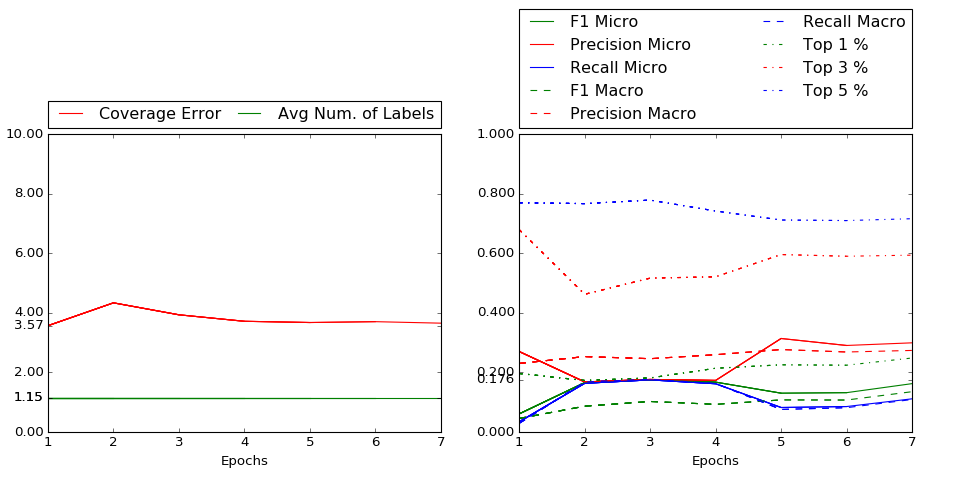

2017-02-17 00:58:47,851 : INFO : ****************** Epoch 1 --- Working on doc2vec_size_100_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1 *******************
2017-02-17 00:58:47,854 : INFO : training model with 22 workers on 391521 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=10
2017-02-17 00:58:47,854 : INFO : expecting 1651226 sentences, matching count from corpus used for vocabulary survey
2017-02-17 00:58:47,861 : INFO : Loading new batch for index: 0
2017-02-17 00:59:00,039 : INFO : Finished loading new batch
2017-02-17 00:59:00,670 : INFO : PROGRESS: at 0.00% examples, 268 words/s, in_qsize 42, out_qsize 1
2017-02-17 00:59:20,667 : INFO : PROGRESS: at 0.25% examples, 553990 words/s, in_qsize 44, out_qsize 2
2017-02-17 00:59:40,670 : INFO : PROGRESS: at 0.54% examples, 705531 words/s, in_qsize 43, out_qsize 0
2017-02-17 01:00:00,397 : INFO : Loading new batch for index: 10000
2017-02-17 01:00:00,668 : INFO : PROGRESS: at 0.78% ex

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.573, Avg Labels: 1.150, 
		 Top 1: 0.197, Top 3: 0.680, Top 5: 0.770, 
		 F1 Micro: 0.061, F1 Macro: 0.046, Total Pos: 46,968


/home/s/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1, right=1
  'left=%s, right=%s') % (left, right))
2017-02-17 06:20:33,430 : INFO : ****************** Epoch 2 --- Working on doc2vec_size_100_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2 *******************
2017-02-17 06:20:33,444 : INFO : training model with 22 workers on 391521 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=10
2017-02-17 06:20:33,445 : INFO : expecting 1651226 sentences, matching count from corpus used for vocabulary survey
2017-02-17 06:20:33,467 : INFO : Loading new batch for index: 0
2017-02-17 06:20:44,891 : INFO : Finished loading new batch
2017-02-17 06:20:46,201 : INFO : PROGRESS: at 0.00% examples, 317 words/s, in_qsize 11, out_qsize 0
2017-02-17 06:21:06,206 : INFO : PROGRESS: at 0.23% e

[[0 1 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 ..., 
 [0 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 [0 1 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 4.340, Avg Labels: 1.150, 
		 Top 1: 0.173, Top 3: 0.463, Top 5: 0.767, 
		 F1 Micro: 0.166, F1 Macro: 0.087, Total Pos: 359,172


2017-02-17 11:46:29,400 : INFO : ****************** Epoch 3 --- Working on doc2vec_size_100_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3 *******************
2017-02-17 11:46:29,402 : INFO : training model with 22 workers on 391521 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=10
2017-02-17 11:46:29,403 : INFO : expecting 1651226 sentences, matching count from corpus used for vocabulary survey
2017-02-17 11:46:29,415 : INFO : Loading new batch for index: 0
2017-02-17 11:46:41,751 : INFO : Finished loading new batch
2017-02-17 11:46:42,086 : INFO : PROGRESS: at 0.00% examples, 317 words/s, in_qsize 44, out_qsize 0
2017-02-17 11:47:02,100 : INFO : PROGRESS: at 0.24% examples, 524604 words/s, in_qsize 39, out_qsize 6
2017-02-17 11:47:22,099 : INFO : PROGRESS: at 0.50% examples, 649959 words/s, in_qsize 43, out_qsize 1
2017-02-17 11:47:42,102 : INFO : PROGRESS: at 0.75% examples, 706070 words/s, in_qsize 43, out_qsize 0
2017-02-17 11:47:48

[[0 1 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 [0 1 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.938, Avg Labels: 1.150, 
		 Top 1: 0.182, Top 3: 0.517, Top 5: 0.779, 
		 F1 Micro: 0.176, F1 Macro: 0.103, Total Pos: 366,238


2017-02-17 17:07:21,790 : INFO : ****************** Epoch 4 --- Working on doc2vec_size_100_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4 *******************
2017-02-17 17:07:21,791 : INFO : training model with 22 workers on 391521 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=10
2017-02-17 17:07:21,792 : INFO : expecting 1651226 sentences, matching count from corpus used for vocabulary survey
2017-02-17 17:07:21,799 : INFO : Loading new batch for index: 0
2017-02-17 17:07:33,073 : INFO : Finished loading new batch
2017-02-17 17:07:34,366 : INFO : PROGRESS: at 0.00% examples, 321 words/s, in_qsize 43, out_qsize 1
2017-02-17 17:07:54,370 : INFO : PROGRESS: at 0.24% examples, 526435 words/s, in_qsize 44, out_qsize 5
2017-02-17 17:08:14,370 : INFO : PROGRESS: at 0.50% examples, 653105 words/s, in_qsize 44, out_qsize 0
2017-02-17 17:08:34,377 : INFO : PROGRESS: at 0.75% examples, 710219 words/s, in_qsize 42, out_qsize 4
2017-02-17 17:08:40

[[0 1 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 ..., 
 [0 1 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.720, Avg Labels: 1.150, 
		 Top 1: 0.214, Top 3: 0.522, Top 5: 0.743, 
		 F1 Micro: 0.168, F1 Macro: 0.093, Total Pos: 345,462


2017-02-17 22:26:32,026 : INFO : ****************** Epoch 5 --- Working on doc2vec_size_100_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_5 *******************
2017-02-17 22:26:32,027 : INFO : training model with 22 workers on 391521 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=10
2017-02-17 22:26:32,028 : INFO : expecting 1651226 sentences, matching count from corpus used for vocabulary survey
2017-02-17 22:26:32,040 : INFO : Loading new batch for index: 0
2017-02-17 22:26:43,235 : INFO : Finished loading new batch
2017-02-17 22:26:44,007 : INFO : PROGRESS: at 0.00% examples, 337 words/s, in_qsize 44, out_qsize 1
2017-02-17 22:27:04,024 : INFO : PROGRESS: at 0.24% examples, 539894 words/s, in_qsize 44, out_qsize 4
2017-02-17 22:27:24,032 : INFO : PROGRESS: at 0.50% examples, 665530 words/s, in_qsize 43, out_qsize 2
2017-02-17 22:27:44,028 : INFO : PROGRESS: at 0.76% examples, 722700 words/s, in_qsize 43, out_qsize 0
2017-02-17 22:27:49

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.679, Avg Labels: 1.150, 
		 Top 1: 0.226, Top 3: 0.596, Top 5: 0.712, 
		 F1 Micro: 0.130, F1 Macro: 0.108, Total Pos: 96,778


2017-02-18 03:43:40,649 : INFO : ****************** Epoch 6 --- Working on doc2vec_size_100_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6 *******************
2017-02-18 03:43:40,650 : INFO : training model with 22 workers on 391521 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=10
2017-02-18 03:43:40,651 : INFO : expecting 1651226 sentences, matching count from corpus used for vocabulary survey
2017-02-18 03:43:40,658 : INFO : Loading new batch for index: 0
2017-02-18 03:43:52,883 : INFO : Finished loading new batch
2017-02-18 03:43:53,295 : INFO : PROGRESS: at 0.00% examples, 318 words/s, in_qsize 1, out_qsize 0
2017-02-18 03:44:13,299 : INFO : PROGRESS: at 0.24% examples, 526645 words/s, in_qsize 42, out_qsize 2
2017-02-18 03:44:33,302 : INFO : PROGRESS: at 0.50% examples, 654518 words/s, in_qsize 44, out_qsize 0
2017-02-18 03:44:53,312 : INFO : PROGRESS: at 0.75% examples, 712868 words/s, in_qsize 43, out_qsize 3
2017-02-18 03:44:58,

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [1 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.707, Avg Labels: 1.150, 
		 Top 1: 0.224, Top 3: 0.591, Top 5: 0.710, 
		 F1 Micro: 0.132, F1 Macro: 0.107, Total Pos: 108,603


2017-02-18 09:00:08,279 : INFO : ****************** Epoch 7 --- Working on doc2vec_size_100_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_7 *******************
2017-02-18 09:00:08,280 : INFO : training model with 22 workers on 391521 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=10
2017-02-18 09:00:08,281 : INFO : expecting 1651226 sentences, matching count from corpus used for vocabulary survey
2017-02-18 09:00:08,289 : INFO : Loading new batch for index: 0
2017-02-18 09:00:18,970 : INFO : Finished loading new batch
2017-02-18 09:00:20,374 : INFO : PROGRESS: at 0.00% examples, 333 words/s, in_qsize 10, out_qsize 0
2017-02-18 09:00:40,370 : INFO : PROGRESS: at 0.24% examples, 532653 words/s, in_qsize 44, out_qsize 0
2017-02-18 09:01:00,374 : INFO : PROGRESS: at 0.50% examples, 658767 words/s, in_qsize 42, out_qsize 2
2017-02-18 09:01:20,384 : INFO : PROGRESS: at 0.75% examples, 717934 words/s, in_qsize 44, out_qsize 2
2017-02-18 09:01:25

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [1 1 1 ..., 0 0 0]
 [1 0 1 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.657, Avg Labels: 1.150, 
		 Top 1: 0.249, Top 3: 0.594, Top 5: 0.717, 
		 F1 Micro: 0.162, F1 Macro: 0.135, Total Pos: 137,367


2017-02-18 14:17:03,965 : INFO : ****************** Epoch 8 --- Working on doc2vec_size_100_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8 *******************
2017-02-18 14:17:03,968 : INFO : training model with 22 workers on 391521 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=10
2017-02-18 14:17:03,969 : INFO : expecting 1651226 sentences, matching count from corpus used for vocabulary survey
2017-02-18 14:17:03,980 : INFO : Loading new batch for index: 0
2017-02-18 14:17:14,042 : INFO : Finished loading new batch
2017-02-18 14:17:15,160 : INFO : PROGRESS: at 0.00% examples, 364 words/s, in_qsize 15, out_qsize 0
2017-02-18 14:17:35,153 : INFO : PROGRESS: at 0.24% examples, 542891 words/s, in_qsize 39, out_qsize 3


In [ ]:
%%time
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph(len(classifications) +2)
# when resuming, resume from an epoch with a previously created doc2vec model to get the learning rate right
start_from = 1
for epoch in range(start_from, DOC2VEC_MAX_EPOCHS+1):
    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    info("****************** Epoch {} --- Working on {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))
    
    # if we have the model, just load it, otherwise train the previous model
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
        doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
    else:
        # train the doc2vec model
        training_docs_iterator = DocumentBatchGenerator(training_preprocessed_files_prefix, 
                                                        training_preprocessed_docids_files_prefix, batch_size=10000)
        doc2vec_model.train(sentences=training_docs_iterator, report_delay=REPORT_DELAY)
        doc2vec_model.alpha -= DOC2VEC_ALPHA_DECREASE  # decrease the learning rate
        doc2vec_model.min_alpha = doc2vec_model.alpha  # fix the learning rate, no decay
        ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME))
        doc2vec_model.save(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
        
        # get the word2vec analogy accuracy score
#         word2vec_result = doc2vec_model.accuracy(word2vec_questions_file, restrict_vocab=None)
#         epoch_word2vec_metrics.append(word2vec_result)
#         pickle.dump(word2vec_result, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME,
#                                                        WORD2VEC_METRICS_FILENAME), 'w'))


    ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                             GLOBAL_VARS.SVM_MODEL_NAME))
    
    if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, CLASSIFIER)):

        info('Getting training Data')
        X, y = get_training_data(doc2vec_model, classifications)
        
        info('Training Classifier')
        clf = OneVsRestClassifier(linear_model.SGDClassifier(loss='hinge', penalty='l2', 
                                                             #alpha is the 1/C parameter
                                                             alpha=SVM_REG, fit_intercept=True, n_iter=SVM_ITERATIONS,
                                                             #n_jobs=-1 means use all cpus
                                                             shuffle=True, verbose=0, n_jobs=1,
                                                             #eta0 is the learning rate when we use constant configuration
                                                             random_state=SVM_SEED, learning_rate='optimal', eta0=0.0, 
                                                             class_weight=SVM_CLASS_WEIGHTS, warm_start=False), n_jobs=1)


        # Training of a classifier
        clf.fit(X,y)
        pickle.dump(clf, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                              GLOBAL_VARS.SVM_MODEL_NAME, CLASSIFIER), 'w'))
        
    #     # Training Metrics
    #     info('Evaluating on Training Data')
    #     yp = clf.predict(X)
    #     yp_score = clf.decision_function(X)
    #     print yp
    #     training_metrics = get_metrics(y, yp_score, yp)
    #     print "** Training Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
    #         training_metrics['coverage_error'], training_metrics['average_num_of_labels'], 
    #         training_metrics['top_1'], training_metrics['top_3'], training_metrics['top_5'], 
    #         training_metrics['f1_micro'], training_metrics['f1_macro'], training_metrics['total_positive'])

    #     epoch_training_metrics.append(training_metrics)
          # Saving the metrics
    #     pickle.dump(training_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
    #                                                           GLOBAL_VARS.SVM_MODEL_NAME, TRAINING_METRICS_FILENAME), 'w'))
        del X, y

    else:
        info('Loading Classifier')
        clf = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, CLASSIFIER), 'r'))

    # Validation Metrics
    info('Getting Validation Embeddings')
    Xv, yv = get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                                    validation_docs_list, validation_preprocessed_files_prefix,
                                                    validation_preprocessed_docids_files_prefix)
    info('Evaluating on Validation Data')
    yvp = clf.predict(Xv)
    yvp_score = clf.decision_function(Xv)
    print yvp
    validation_metrics = get_metrics(yv, yvp_score, yvp)
    print "** Validation Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
        validation_metrics['coverage_error'], validation_metrics['average_num_of_labels'], 
        validation_metrics['top_1'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'], validation_metrics['total_positive'])
    
    graph.add_metrics_to_graph(validation_metrics, epoch)
    
    epoch_validation_metrics.append(validation_metrics)
    
    
    # Saving the metrics
#     pickle.dump(training_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
#                                                           GLOBAL_VARS.SVM_MODEL_NAME, TRAINING_METRICS_FILENAME), 'w'))
    pickle.dump(validation_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, VALIDATION_METRICS_FILENAME), 'w'))


In [36]:
GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(6)
info("****************** Epoch {} --- Working on {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))

# if we have the model, just load it, otherwise train the previous model
if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
    doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))

2017-01-07 08:32:48,888 : INFO : ****************** Epoch 6 --- Working on doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6 *******************
2017-01-07 08:32:48,891 : INFO : loading Doc2Vec object from /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model
2017-01-07 08:33:14,046 : INFO : loading docvecs recursively from /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.docvecs.* with mmap=None
2017-01-07 08:33:14,048 : INFO : loading doctag_syn0 from /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-07 08:33:21,936 : INFO : loading syn1neg from /big/s/shalaby/parameter_search_doc2vec_mode

In [35]:
%%time
ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME))
doc2vec_model.save(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

# get the word2vec analogy accuracy score
%time word2vec_result = doc2vec_model.accuracy(word2vec_questions_file, restrict_vocab=None)
epoch_word2vec_metrics.append(word2vec_result)
pickle.dump(word2vec_result, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME,
                                               WORD2VEC_METRICS_FILENAME), 'w'))


2017-01-07 08:05:32,383 : INFO : saving Doc2Vec object under /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model, separately None
2017-01-07 08:05:32,384 : INFO : storing numpy array 'doctag_syn0' to /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.docvecs.doctag_syn0.npy
2017-01-07 08:06:07,546 : INFO : storing numpy array 'syn1neg' to /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.syn1neg.npy
2017-01-07 08:06:22,413 : INFO : not storing attribute syn0norm
2017-01-07 08:06:22,414 : INFO : storing numpy array 'syn0' to /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.syn

CPU times: user 3h 47min 44s, sys: 4h 31min 2s, total: 8h 18min 46s
Wall time: 21min 14s
CPU times: user 3h 48min 38s, sys: 4h 31min 12s, total: 8h 19min 51s
Wall time: 23min 18s
